# Loading and Analysing Pre-Trained Sparse Autoencoders

## Imports & Installs

## Set Up

In [19]:
import os
import pandas as pd
import numpy as np
import shutil
import json
import random
import networkx as nx
import matplotlib.pyplot as plt


from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search
from causallearn.utils.cit import kci
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.cit import fisherz

In [20]:
blue_color = '#42A5F5'
yellow_color = '#FFCA28'


#T2P
answer_valuebench_features_csv_gemma_train = os.path.join('useful_data',"ans_gemma_train_formal.csv")
answer_valuebench_features_csv_gemma_test = os.path.join('useful_data',"ans_gemma_test_formal.csv")
answer_valuebench_features_csv_llama_train = os.path.join('useful_data',"ans_llama_train_formal.csv")
answer_valuebench_features_csv_llama_test = os.path.join('useful_data',"ans_llama_test_formal.csv")
# answer_valuebench_features_csv_gemma_train = os.path.join('useful_data',"ans_cross_part1.csv")
# answer_valuebench_features_csv_gemma_test = os.path.join('useful_data',"ans_cross_part2.csv")
# answer_valuebench_features_csv_llama_train = os.path.join('useful_data',"ans_llama_old_train.csv")
# answer_valuebench_features_csv_llama_test = os.path.join('useful_data',"ans_llama_old_test.csv")

data_csv_gemma_train = pd.read_csv(answer_valuebench_features_csv_gemma_train)
data_csv_gemma_test = pd.read_csv(answer_valuebench_features_csv_gemma_test)
data_csv_llama_train = pd.read_csv(answer_valuebench_features_csv_llama_train)
data_csv_llama_test = pd.read_csv(answer_valuebench_features_csv_llama_test)

#T2P

exclude_columns_gemma = ['Anxiety Disorder', 'Achievement', 'Empathy', 'Organization', 'Political', 'Economic', 'Social Complexity']
#exclude_rows_gemma = [14351, 12703, 10454, 8387, 6884, 6126, 6188, 2221,1025, 428,]
gemma_features = [14351, 12703, 10454, 8387, 6884, 6126, 6188, 2221,1025, 428, 1312,1341,1975,2965,3183,3402,4752,6216,6619,7502,10096,10605,11712,14049,14185]
good_gemma_features = [14351, 1025, 2965,10096, 1341, 1975 , 10605, 14049, 1312,4752 ]# ,3402, 
# exclude_columns_gemma = []
# good_gemma_features = gemma_features
exclude_rows_gemma = [i for i in gemma_features if i not in good_gemma_features]



exclude_columns_llama = ['Anxiety Disorder', 'Achievement', 'Empathy', 'Organization', 'Political', 'Economic', 'Social Complexity']
#exclude_rows_llama = [60312, 7754, 13033, 1897, 2509, 20141, 41929, 48321, 63905, 49202, 2246, 58305,]
llama_features = [63905, 48321, 1897, 2509, 60312, 7754, 49202, 2246, 13033, 58305, 41929, 20141, 12477, 54606, 21347, 4305, 30919, 34598, 51010, 62769, 47207, 8035, 8546, 9332]
good_llama_features = [49202, 58305, 8546, 12477, 7754, 9332, 1897,  62769, 47207, 12477, 54606] #best 49202, 58305, 8546 #okay 13033, 12477, 21347, 4305, 62769, 47207, 2509 
#20141,  54606
# exclude_columns_llama = []
# good_llama_features = llama_features
exclude_rows_llama = [i for i in llama_features if i not in good_llama_features]

data_csv_gemma_train = data_csv_gemma_train[~data_csv_gemma_train['steer_dim'].isin(exclude_rows_gemma)]
data_csv_gemma_test = data_csv_gemma_test[~data_csv_gemma_test['steer_dim'].isin(exclude_rows_gemma)]
data_csv_llama_train = data_csv_llama_train[~data_csv_llama_train['steer_dim'].isin(exclude_rows_llama)]
data_csv_llama_test = data_csv_llama_test[~data_csv_llama_test['steer_dim'].isin(exclude_rows_llama)]



In [21]:
def get_data_new_diff(data_csv_raw, modelname, threshold_judge):
    assert threshold_judge >= 0
    pathname = 'value_dims_rsd_' + modelname
    stat_csv_23 = pathname + '/23_stat.csv'
    data_new_diff_count_total = pd.DataFrame()

    if os.path.exists(pathname):
        shutil.rmtree(pathname)
    os.makedirs(pathname, exist_ok=True)
    
    for column in data_csv_raw.columns:
        if column == 'player_name' or column == 'steer_dim' or column == 'stds' or column =='scstds' or column.endswith(':scstd'):
            continue
        value_csv = pathname + '/' + column + '.csv'
        data_new = data_csv_raw.pivot(index='steer_dim', columns='player_name', values=column)
        data_new_scstd = data_csv_raw.pivot(index='steer_dim', columns='player_name', values=column+':scstd')
        data_save = data_new.astype(str) + '±' + data_new_scstd.astype(str) #problems here: the scstd is not the std for the score, but fore the changed score
        data_save.to_csv(value_csv)

        data_new_diff = data_new - data_new[data_new.index.isnull()].iloc[0]

        data_new_diff_count_higher = data_new_diff.apply(lambda x: x.apply(lambda y: 1 if y > threshold_judge else 0))
        data_new_diff_count_higher = data_new_diff_count_higher.sum(axis=1)
        data_new_diff_count_lower = data_new_diff.apply(lambda x: x.apply(lambda y: 1 if y < -threshold_judge else 0))
        data_new_diff_count_lower = data_new_diff_count_lower.sum(axis=1)
        data_new_diff_count_equal = data_new_diff.apply(lambda x: x.apply(lambda y: 1 if abs(y) <= threshold_judge else 0))
        data_new_diff_count_equal = data_new_diff_count_equal.sum(axis=1)

        data_new_diff_count = data_new_diff_count_higher.astype(str) + '/' + data_new_diff_count_lower.astype(str) + '/' + data_new_diff_count_equal.astype(str)
        data_new_diff_count_total[column] = data_new_diff_count

    data_new_diff_count_total.to_csv(stat_csv_23)

get_data_new_diff(data_csv_gemma_train, 'gemma', threshold_judge=0)
get_data_new_diff(data_csv_gemma_test, 'gemmatest', threshold_judge=0)
get_data_new_diff(data_csv_llama_train, 'llama', threshold_judge=0)
get_data_new_diff(data_csv_llama_test, 'llamatest', threshold_judge=0)

In [22]:
def get_table1_newest(stat_csv_23_train, stat_csv_23_test):
    data_new_diff_count_total_train = pd.read_csv(stat_csv_23_train)
    data_new_diff_count_total_test = pd.read_csv(stat_csv_23_test)

    table1_rows = data_new_diff_count_total_train['steer_dim'].unique()
    table1_rows = table1_rows[~np.isnan(table1_rows)]
    table1_columns = data_new_diff_count_total_train.columns[data_new_diff_count_total_train.columns != 'steer_dim']

    table1_rows_test = data_new_diff_count_total_test['steer_dim'].unique()
    table1_rows_test = table1_rows_test[~np.isnan(table1_rows_test)]
    table1_columns_test = data_new_diff_count_total_test.columns[data_new_diff_count_total_test.columns != 'steer_dim']

    assert np.array_equal(table1_rows, table1_rows_test)
    assert np.array_equal(table1_columns, table1_columns_test)
    
    table1 = pd.DataFrame(columns=table1_columns, index=table1_rows)
    
    for steer_dim in table1_rows:
        assert not np.isnan(steer_dim)

        steer_dim_row_train = data_new_diff_count_total_train[data_new_diff_count_total_train['steer_dim'] == steer_dim]
        steer_dim_row_test = data_new_diff_count_total_test[data_new_diff_count_total_test['steer_dim'] == steer_dim]

        for column in table1_columns:
            assert column != 'steer_dim'
            #split cell by /
            counts_train = steer_dim_row_train[column].values[0].split('/')   
            simu_train = int(counts_train[0])
            supp_train = int(counts_train[1])
            main_train = int(counts_train[2])
            
            counts_test = steer_dim_row_test[column].values[0].split('/')
            simu_test = int(counts_test[0])
            supp_test = int(counts_test[1])
            main_test = int(counts_test[2])

            table1.loc[steer_dim, column] = str(simu_train) + '/' + str(supp_train) + '/' + str(main_train) + '/' + str(simu_test) + '/' + str(supp_test) + '/' + str(main_test)
    return table1

table1_gemma = get_table1_newest('value_dims_rsd_gemma/23_stat.csv', 'value_dims_rsd_gemmatest/23_stat.csv')
table1_gemma.to_csv('table1_gemma_newest.csv')
table1_llama = get_table1_newest('value_dims_rsd_llama/23_stat.csv', 'value_dims_rsd_llamatest/23_stat.csv')
table1_llama.to_csv('table1_llama_newest.csv')

Positive coping 4.0
Positive coping -10.0
++++++++++
Theoretical 5.0
Theoretical 12.0
++++++++++
Uncertainty Avoidance 11.0
Uncertainty Avoidance -7.0
++++++++++
Aesthetic -5.0
Aesthetic -5.0
++++++++++
Breadth of Interest 9.0
Breadth of Interest -9.0
++++++++++
Religious 2.0
Religious -11.0
++++++++++
Social 5.0
Social 4.0
++++++++++
Understanding 7.0
Understanding 18.0
++++++++++
Resilience -2.0
Resilience -2.0
++++++++++
Social Cynicism 16.0
Social Cynicism -2.0
++++++++++
Aesthetic -8.0
Aesthetic -21.0
++++++++++
Resilience -17.0
Resilience -26.0
++++++++++
Social Cynicism -25.0
Social Cynicism 4.0
++++++++++
Positive coping -13.0
Positive coping -19.0
++++++++++
Religious -14.0
Religious -26.0
++++++++++
Breadth of Interest -9.0
Breadth of Interest -22.0
++++++++++
Understanding -4.0
Understanding 10.0
++++++++++
Theoretical -4.0
Theoretical -11.0
++++++++++
Uncertainty Avoidance -3.0
Uncertainty Avoidance -21.0
++++++++++
Social 0.0
Social -20.0
++++++++++
Positive coping -6.0
Po

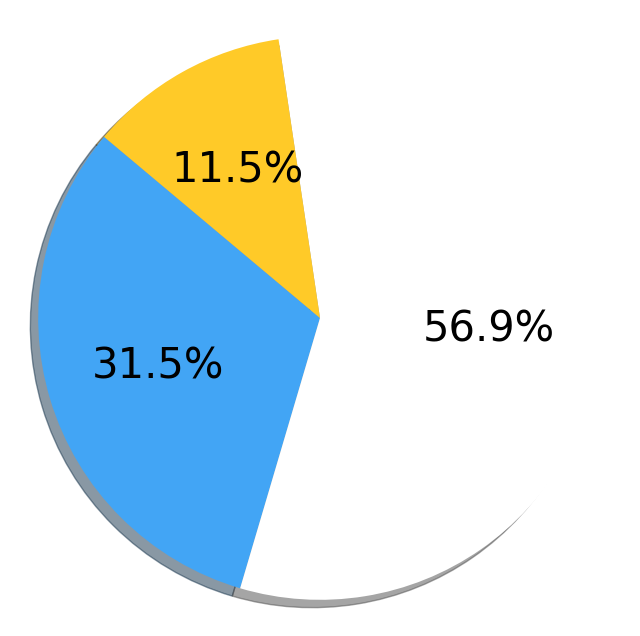

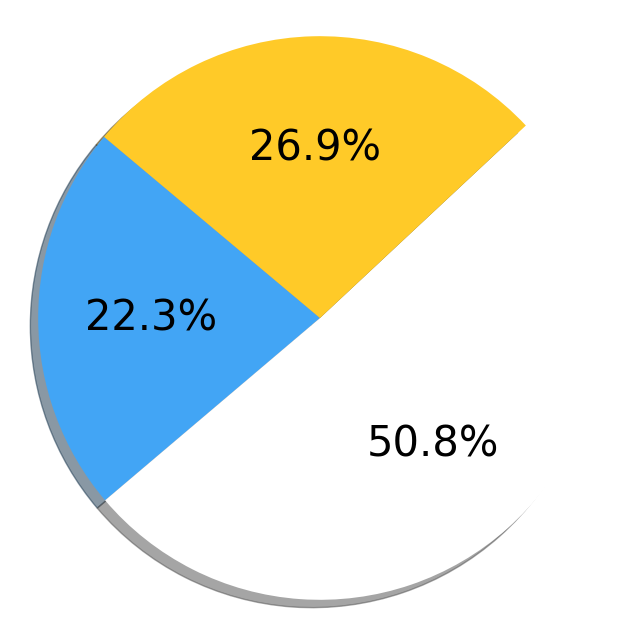

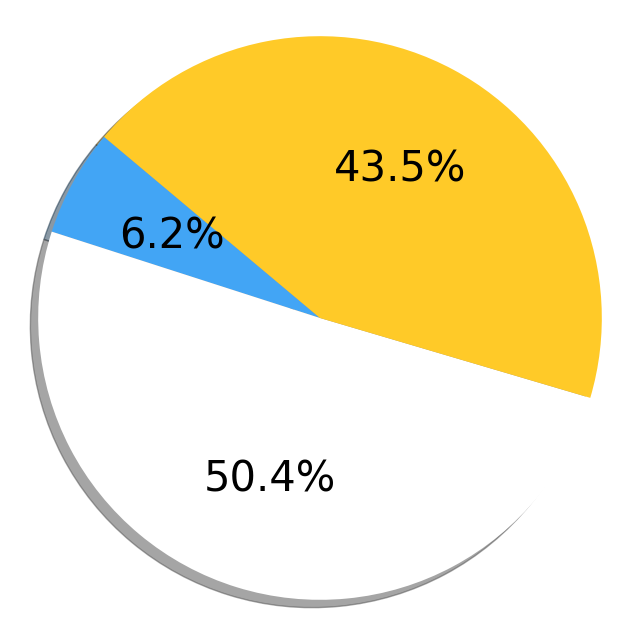

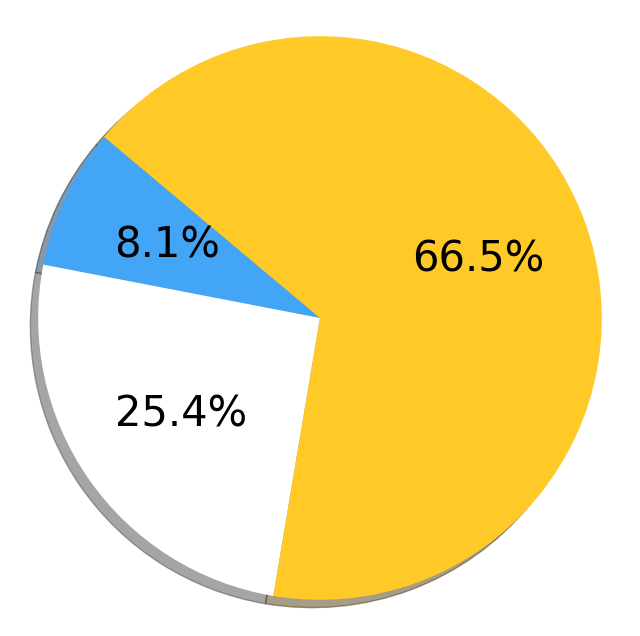

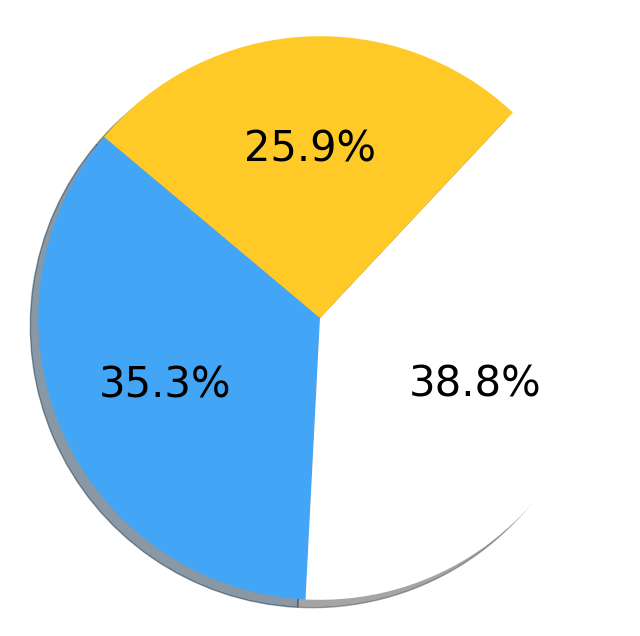

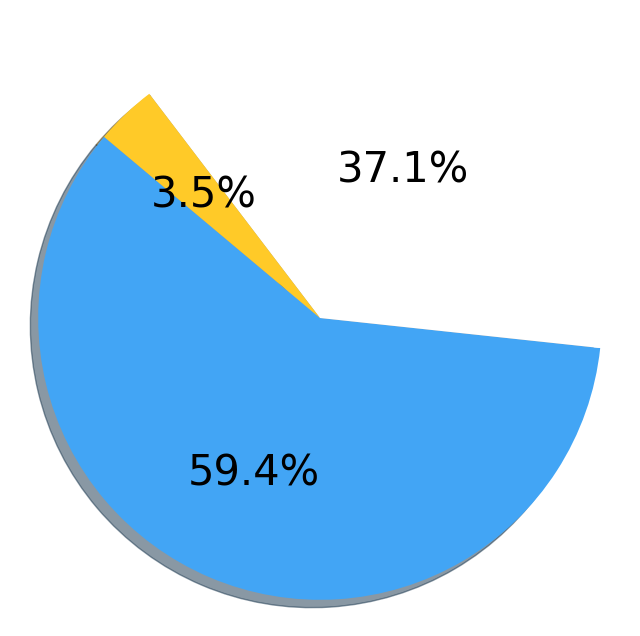

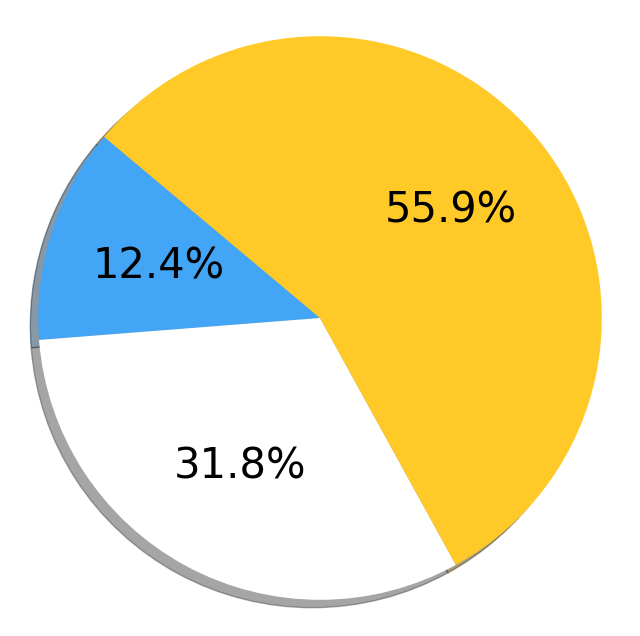

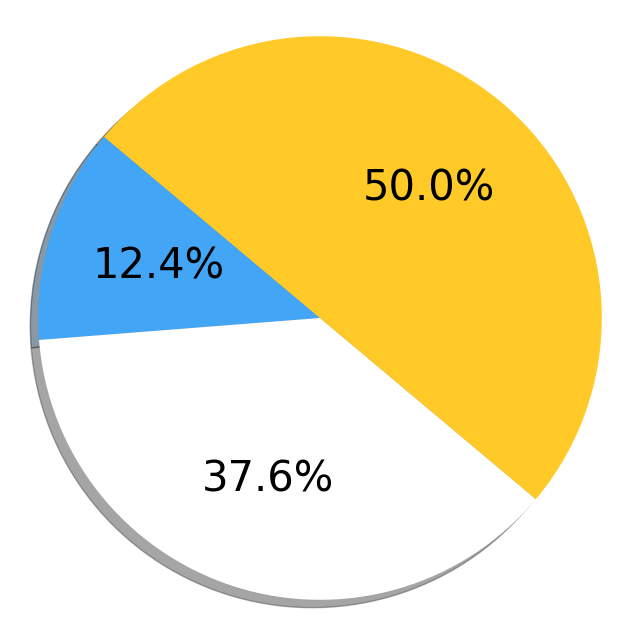

In [23]:
answer_valuebench_features_csv_gemma_compare_positve = os.path.join('useful_data',"ans_gemma_test_compare_positive_s1.csv")
answer_valuebench_features_csv_gemma_compare_negative = os.path.join('useful_data',"ans_gemma_test_compare_negative_s1.csv")
answer_valuebench_features_csv_llama_compare_positve = os.path.join('useful_data',"ans_llama_test_compare_positive.csv")
answer_valuebench_features_csv_llama_compare_negative = os.path.join('useful_data',"ans_llama_test_compare_negative.csv")
data_csv_gemma_compare_positive = pd.read_csv(answer_valuebench_features_csv_gemma_compare_positve)
data_csv_gemma_compare_negative = pd.read_csv(answer_valuebench_features_csv_gemma_compare_negative)
data_csv_llama_compare_positive = pd.read_csv(answer_valuebench_features_csv_llama_compare_positve)
data_csv_llama_compare_negative = pd.read_csv(answer_valuebench_features_csv_llama_compare_negative)

# for each value, check the status of all roles in data_csv_gemma_test without sae steer
value_steers_gemma_negative = {'Aesthetic': 10605, 'Resilience':4752, 'Social Cynicism': 4752, 'Positive coping':10096, 'Religious':1341, 'Breadth of Interest': 14049, 'Understanding':1975,'Theoretical':1975, 'Uncertainty Avoidance':4752,  'Social':1975, } #'
value_steers_gemma_positive = {'Positive coping':1975, 'Theoretical': 10096, 'Uncertainty Avoidance': 1312, 'Aesthetic': 1312, 'Breadth of Interest':10096, 'Religious':1312, 'Social':14049, 'Understanding':4752,  'Resilience': 1341, 'Social Cynicism': 14049}
value_steers_llama_negative = {'Aesthetic': 58305, 'Resilience':7754, 'Social Cynicism': 47207, 'Positive coping':7754, 'Religious':47207, 'Breadth of Interest': 7754, 'Understanding':7754,'Theoretical':7754, 'Uncertainty Avoidance':12477,  'Social':7754, } #'
value_steers_llama_positive = {'Positive coping':9332, 'Theoretical': 9332, 'Uncertainty Avoidance': 7754, 'Aesthetic': 49202, 'Breadth of Interest': 58305, 'Religious':9332, 'Social': 54606, 'Understanding':47207,  'Resilience': 9332, 'Social Cynicism': 7754}#Uncertainty Avoidance':62769


#check data_csv_gemma_test, pay attention to the values in value_steers_gemma_negative, check the difference between the not doing steering and doing steering using the saes in value_steers_gemma_negative
def steer_compare(sae_dict, data_csv,  data_csv_compare):
    from collections import Counter
    changed_roles_sae = Counter()
    changed_roles_compare = Counter()
    for value_name, steer in sae_dict.items():
        data_csv_steering_none = data_csv[np.isnan(data_csv['steer_dim'])][['player_name', value_name]]
        data_csv_steering_bestsae = data_csv[data_csv['steer_dim'] == steer][['player_name', value_name]]
        data_csv_steering_compare = data_csv_compare[['player_name', value_name]]
        data_csv_steering_compare = data_csv_steering_compare[data_csv_steering_compare['player_name'].isin(data_csv_steering_none['player_name'])]
        assert data_csv_steering_none['player_name'].tolist() == data_csv_steering_bestsae['player_name'].tolist() == data_csv_steering_compare['player_name'].tolist()
        

        
        diff1 = data_csv_steering_bestsae[value_name].to_numpy() - data_csv_steering_none[value_name].to_numpy()
        diff2 = data_csv_steering_compare[value_name].to_numpy() - data_csv_steering_none[value_name].to_numpy()
        #map diff1 to -1, 0, 1
        changed_roles_sae['positive'] += np.sum(np.sign(diff1) == 1)
        changed_roles_sae['negative'] += np.sum(np.sign(diff1) == -1)
        changed_roles_sae['zero'] += np.sum(np.sign(diff1) == 0)
        changed_roles_compare['positive'] += np.sum(np.sign(diff2) == 1)
        changed_roles_compare['negative'] += np.sum(np.sign(diff2) == -1)
        changed_roles_compare['zero'] += np.sum(np.sign(diff2) == 0)
        print(value_name, np.sum(np.sign(diff1)))
        print(value_name, np.sum(np.sign(diff2)))
        print('++++++++++')
        # changed_roles_sae.append(sign * np.sum(np.sign(diff1)))
        # changed_roles_compare.append(sign * np.sum(np.sign(diff2)))
        
    return changed_roles_sae, changed_roles_compare
change_roles_sae_gemma_postive, changed_roles_compare_gemma_positive = steer_compare(value_steers_gemma_positive, data_csv_gemma_test, data_csv_gemma_compare_positive)
change_roles_sae_gemma_negative, changed_roles_compare_gemma_negative = steer_compare(value_steers_gemma_negative, data_csv_gemma_test, data_csv_gemma_compare_negative)
change_roles_sae_llama_postive, changed_roles_compare_llama_positive = steer_compare(value_steers_llama_positive, data_csv_llama_test, data_csv_llama_compare_positive)
change_roles_sae_llama_negative, changed_roles_compare_llama_negative = steer_compare(value_steers_llama_negative, data_csv_llama_test, data_csv_llama_compare_negative)

#draw a 1*2 table of pie charts, each pie chart shows the percentage of positive, negative, and zero changes in the roles
#the columns are the SAE and the compare
#begin

import matplotlib.pyplot as plt
def draw_pie_chart(count_1, count_0, count_neg1, steer_method):
    labels = ['Positively Changed Roles', 'Unchanged Roles', 'Negatively Changed Roles']
    sizes = [count_1, count_0, count_neg1]
    colors = [blue_color, '#ffffff', yellow_color]
    
    
    explode = (0, 0, 0)  # explode the 1st slice (Positive)

    # Create the pie chart
    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, labeldistance=0.85, textprops={'fontsize': 30})
    #plt.legend(wedges, labels, title="Role Changes", loc="center", bbox_to_anchor=(0.5, 0, 0.5, 1))

    #plt.title('Value Changing Direction Results for ' + steer_method)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # centre_circle = plt.Circle((0,0),0.70,fc='white')
    # fig = plt.gcf()
    # fig.gca().add_artist(centre_circle)

draw_pie_chart(change_roles_sae_gemma_postive['positive'], change_roles_sae_gemma_postive['zero'], change_roles_sae_gemma_postive['negative'], 'Positive SAE Steering on Gemma-2B-IT')
draw_pie_chart(changed_roles_compare_gemma_positive['positive'], changed_roles_compare_gemma_positive['zero'], changed_roles_compare_gemma_positive['negative'], 'Positive Hard Prompt on Gemma-2B-IT')
draw_pie_chart(change_roles_sae_gemma_negative['positive'], change_roles_sae_gemma_negative['zero'], change_roles_sae_gemma_negative['negative'], 'Negative SAE Steering on Gemma-2B-IT')
draw_pie_chart(changed_roles_compare_gemma_negative['positive'], changed_roles_compare_gemma_negative['zero'], changed_roles_compare_gemma_negative['negative'], 'Negative Hard Prompt on Gemma-2B-IT')
draw_pie_chart(change_roles_sae_llama_postive['positive'], change_roles_sae_llama_postive['zero'], change_roles_sae_llama_postive['negative'], 'Positive SAE Steering on LLAMA3-8B-IT')
draw_pie_chart(changed_roles_compare_llama_positive['positive'], changed_roles_compare_llama_positive['zero'], changed_roles_compare_llama_positive['negative'], 'Positive Hard Prompt on LLAMA3-8B-IT')
draw_pie_chart(change_roles_sae_llama_negative['positive'], change_roles_sae_llama_negative['zero'], change_roles_sae_llama_negative['negative'], 'Negative SAE Steering on LLAMA3-8B-IT')
draw_pie_chart(changed_roles_compare_llama_negative['positive'], changed_roles_compare_llama_negative['zero'], changed_roles_compare_llama_negative['negative'], 'Negative Hard Prompt on LLAMA3-8B-IT')


In [24]:
def get_best_steer_of_value(data_test_csv, value):
    data_test_csv = data_test_csv[data_test_csv['steer_dim'] == value]
    return 
get_best_steer_of_value(data_csv_gemma_test, 'Aesthetic')

In [25]:
def get_latex_table1_rotate_tutu(table1, table1_name, modelname, exclude_rows=None, exclude_columns=None):
    if exclude_rows is None:
        exclude_rows = []
    if exclude_columns is None:
        exclude_columns = []

    #value_dims = [str(vd) for vd in table1.index if vd not in exclude_rows]
    value_dims = [str(vd) for vd in table1.columns if vd not in exclude_columns]
    #steering_features = [int(sf) for sf in table1.columns if sf not in exclude_columns]
    steering_features = [int(sf) for sf in table1.index if sf not in exclude_rows]

    table_filtered = table1.loc[steering_features, value_dims]

    # 初始化 LaTeX 代码
    latex_code = '''
\\newcommand{\\cellbar}[5]{%
    \\raisebox{\\height}{%
        \\begin{tikzpicture}[baseline=(current bounding box.center)]
            \\draw[draw=black] (0,0) rectangle (1cm,0.4cm);
            \\path[fill=CustomBlue, opacity=#5] (0,0) rectangle (#1cm,0.4cm);
            \\path[fill=white] (#1cm,0) rectangle ({#1cm + #3cm},0.4cm);
            \\path[fill=CustomYellow, opacity=#5] ({#1cm + #3cm},0) rectangle (1cm,0.4cm);
            \\node[anchor=center, font=\\scriptsize] at (0.5cm,0.2cm) {#2};
        \\end{tikzpicture}%
    }%
}
\\begin{table*}
\\centering
\\caption{Value steering using SAE features for the {''' + modelname + '''} model.}
\\label{table: sae-steering-''' + modelname + '''}
\\resizebox{\\textwidth}{!}{%
\\begin{tabular}{>{\\centering\\arraybackslash}m{1.5cm} *{''' + str(len(value_dims)) + '''}{>{\\centering\\arraybackslash}m{1cm}}>{\\centering\\arraybackslash}m{1cm}}
\\toprule
'''


    # 生成表头
    header_row = ['\\diagbox[width=1.8cm, height=2.7cm]{\\textbf{SAE}\\\\\\textbf{Feature}}{\\rotatebox{90}{\\textbf{Value}}}'] + ['\\rotatebox{90}{\\textbf{' + vd + '}}' for vd in value_dims] + ['\\rotatebox{90}{\\textbf{Mean Similarity}}']
    latex_code += ' & '.join(header_row) + ' \\\\\n\\midrule\n'
    latex_code += '\\multicolumn{' + str(len(value_dims)+2) + '}{c}{\\textbf{\\small{' + modelname + '}}}' + ' \\\\\n\\midrule\n'

    # 定义单元格内容的生成函数
    def generate_cell_content(red_ratio, green_ratio, transparency_ratio, similarity):
        """
        生成单元格的 LaTeX 代码，使用 \\cellbar{red_length}{similarity}{transparency_length}{green_length}{opacity}
        """
        # 确保比例在 0 到 1 之间，并归一化
        total = red_ratio + green_ratio + transparency_ratio
        if total > 0:
            red_ratio /= total
            green_ratio /= total
            transparency_ratio /= total
        else:
            red_ratio = green_ratio = transparency_ratio = 0.0

        red_length = red_ratio
        transparency_length = transparency_ratio
        green_length = green_ratio

        opacity = 1.0 - transparency_ratio  # 透明度与透明部分成反比

        return f'\\cellbar{{{red_length:.2f}}}{{{similarity:.2f}}}{{{transparency_length:.2f}}}{{{green_length:.2f}}}{{{opacity:.2f}}}'

    # 生成表格内容
    lowest_ratios = {vd: [] for vd in value_dims} 
    for sf in steering_features:
        cosines = []
        row = ['\\textbf{' + str(sf) + '}']
        for vd in value_dims:
            value = table_filtered.loc[sf, vd]
            if isinstance(value, str):
                # 处理字符串值，计算相似度
                value_list = list(map(int, value.split('/')))
                traindata = value_list[:3]
                testdata = value_list[3:]
                # 计算相似度
                traindata_p = np.array(traindata) / np.sum(traindata)
                testdata_p = np.array(testdata) / np.sum(testdata)
                similarity = np.dot(traindata_p, testdata_p) / (np.linalg.norm(traindata_p) * np.linalg.norm(testdata_p))
                cosines.append(similarity)
                lowest_ratios[vd].append(min(traindata_p))

                # 提取红色、绿色和透明度的值
                red_value = traindata[0]
                green_value = traindata[1]
                transparency_value = traindata[2]
                # 计算比例
                red_ratio = red_value
                green_ratio = green_value
                transparency_ratio = transparency_value

                # 生成单元格内容
                cell_content = generate_cell_content(red_ratio, green_ratio, transparency_ratio, similarity)
                row.append(cell_content)
            else:
                row.append('')

        avg_similarity = np.mean(cosines) if cosines else 0
        row.append(f'{avg_similarity:.2f}')
        latex_code += ' & '.join(row) + ' \\\\\n'
    latex_code += '\\midrule\nNoise Ratio:& ' + '&'.join([f'{np.mean(lowest_ratios[vd]):.2f}' for vd in value_dims]) + ' \\\\\n'
    latex_code += '\\bottomrule\n\\end{tabular}\n}\n\\end{table*}\n'

    # 保存 LaTeX 代码
    with open(f'{table1_name}.tex', 'w') as f:
        f.write(latex_code)
  

get_latex_table1_rotate_tutu(table1_gemma, 'table1_gemma_rotate', 'Gemma-2B-IT', exclude_rows_gemma, exclude_columns_gemma)
get_latex_table1_rotate_tutu(table1_llama, 'table1_llama_rotate', 'Llama3-8B-IT', exclude_rows_llama, exclude_columns_llama)


In [26]:
#T2P
CAUSAL_METHOD = 'pc'
NOISE_AUGUMENT_SINGLE_SAE = None #10
NOISE_VAR = 0.00001
PC_ALPHA = 0.05 #0.0005


In [27]:
def get_valid_d_columns_deprecated(answer_valuebench_features_csv):
    data_csv = pd.read_csv(answer_valuebench_features_csv)
    digits = [str(d) for d in range(10)]
    d_columns = [d for d in data_csv.columns if d[0] in digits]
    d_data = data_csv[d_columns]
    stds = d_data.std()
    avgs = d_data.mean()
    std_avg = stds/avgs
    #d_columns_valid = [d for d in d_columns if avgs[d] > 1]
    d_columns_valid = d_columns
    return d_columns_valid

def get_value_dims_from_csv(data_csv):
    return [v for v in data_csv.columns if (v not in ['player_name', 'steer_dim', 'stds', 'scstds']) and (not v.endswith(':scstd'))]

def causal_inference(data, ci_dimensions, pdy_name, method, noise_augument=None, prior_source_set=None):
    if noise_augument:
        data = np.tile(data, (noise_augument, 1))
        noise = np.random.normal(0, NOISE_VAR, data.shape)
        data = data + noise

    if method == 'pc':
        g = pc(data, PC_ALPHA, node_names=ci_dimensions)
        
        if prior_source_set:
            bk = BackgroundKnowledge()
            nodes = g.G.get_nodes()
            for node1 in nodes:
                for node2 in nodes:
                    if node1.name in prior_source_set and node2.name in prior_source_set and node1.name != node2.name:
                        bk = bk.add_forbidden_by_node(node1, node2)
            g = pc(data, PC_ALPHA, node_names=ci_dimensions, background_knowledge=bk)
            
        graph = g.G

        edges = []
        for n1 in range(len(graph.nodes)):
            assert graph.nodes[n1].name == ci_dimensions[n1]
            for n2 in range(n1+1, len(graph.nodes)):
                # if n1 == n2:
                #     continue
                if graph.graph[n1][n2] == -1 and graph.graph[n2][n1] == 1:
                    edges.append([graph.nodes[n1].name, graph.nodes[n2].name, 1, 'single-arrow'])
                elif graph.graph[n1][n2] == 1 and graph.graph[n2][n1] == -1:
                    edges.append([graph.nodes[n2].name, graph.nodes[n1].name, 1, 'single-arrow']) 
                elif graph.graph[n1][n2] == -1 and graph.graph[n2][n1] == -1:
                    edges.append([graph.nodes[n1].name, graph.nodes[n2].name, 1, 'no-arrow'])
                elif graph.graph[n1][n2] == 1 and graph.graph[n2][n1] == 1:
                    edges.append([graph.nodes[n1].name, graph.nodes[n2].name, 1, 'double-arrow'])
                else:
                    if not (graph.graph[n1][n2] == 0 and graph.graph[n2][n1] == 0):
                        raise ValueError('Invalid edge')
    else:
        raise ValueError('Invalid method')
    
    columns_concerned_vis = [label.replace(':','-') for label in ci_dimensions]
    pdy = GraphUtils.to_pydot(graph, labels=columns_concerned_vis)
    pdy.write_png(pdy_name)
    return edges


def deal_with_csv(data_csv, graph_path, v_showongraph='ALL', row_num='ALL', method=CAUSAL_METHOD, dummy_steered_dim=False): 
    v_inference = get_value_dims_from_csv(data_csv)
    if os.path.exists(graph_path):
        shutil.rmtree(graph_path)
    os.makedirs(graph_path, exist_ok=True)
    
    # data_csv = pd.read_csv(answer_valuebench_features_csv)
    # v_columns_all = [v for v in data_csv.columns if (v not in ['player_name', 'steer_dim', 'stds']) and (not v.endswith(':scstd'))]
    # if v_inference == 'ALL':
    #     v_columns_inference = v_columns_all
    # else:
    #     for v in v_inference:
    #         if v not in v_columns_all:
    #             raise ValueError('Invalid v_inference')
    #     v_columns_inference = v_inference

    v_columns_inference = v_inference

    if v_showongraph == 'ALL':
        v_columns_showgraph = v_columns_inference
    else:
        for v in v_showongraph:
            if v not in v_columns_inference:
                raise ValueError('Invalid v_showongraph')
        v_columns_showgraph = v_showongraph

    if dummy_steered_dim:
        steer_dim_dummies = pd.get_dummies(data_csv['steer_dim'], prefix='steer_dim') * 1
        data = pd.concat([data_csv, steer_dim_dummies], axis=1)
        v_columns_inference_total = v_columns_inference + list(steer_dim_dummies.columns) 
        v_columns_showgraph_total = v_columns_showgraph + list(steer_dim_dummies.columns)
    else:
        data = data_csv
        v_columns_inference_total = v_columns_inference
        v_columns_showgraph_total = v_columns_showgraph
    
    data = data[v_columns_inference_total].to_numpy()    
    
    if type(row_num) == int:
        rows = np.random.choice(data.shape[0], row_num, replace=False)
        data = data[rows]
    else:
        assert row_num == 'ALL'

    if dummy_steered_dim:
        edges_total = causal_inference(data, v_columns_inference_total, graph_path + "/total.png", method, noise_augument=None, prior_source_set=list(steer_dim_dummies.columns))
    else:
        edges_total = causal_inference(data, v_columns_inference_total, graph_path + "/total.png", method, noise_augument=None)
    
    edges_sfs = []
    steer_dims = data_csv['steer_dim'].unique()
    for steer_dim in steer_dims:
        print(steer_dim)
        if np.isnan(steer_dim):
            data = data_csv[data_csv['steer_dim'].isnull()][v_columns_inference].to_numpy()
            edges_nosteer = causal_inference(data, v_columns_inference, graph_path + f'/{steer_dim}.png', method, noise_augument=NOISE_AUGUMENT_SINGLE_SAE)
        else:
            data = data_csv[data_csv['steer_dim'] == steer_dim][v_columns_inference].to_numpy()
            sfedge = causal_inference(data, v_columns_inference, graph_path + f'/{steer_dim}.png', method, noise_augument=NOISE_AUGUMENT_SINGLE_SAE)
            edges_sfs.append(sfedge)

    return edges_total, edges_nosteer, edges_sfs

#T2P
edges_gemma_total, edges_gemma_nosteer, edges_gemma_sfs = deal_with_csv(data_csv_gemma_train, 'value_causal_graph_gemma')
edges_llama_total, edges_llama_nosteer, edges_llama_sfs = deal_with_csv(data_csv_llama_train, 'value_causal_graph_llama')

  0%|          | 0/17 [00:00<?, ?it/s]

nan


  0%|          | 0/17 [00:00<?, ?it/s]

10096.0


  0%|          | 0/17 [00:00<?, ?it/s]

1312.0


  0%|          | 0/17 [00:00<?, ?it/s]

14049.0


  0%|          | 0/17 [00:00<?, ?it/s]

1341.0


  0%|          | 0/17 [00:00<?, ?it/s]

1975.0


  0%|          | 0/17 [00:00<?, ?it/s]

10605.0


  0%|          | 0/17 [00:00<?, ?it/s]

4752.0


  0%|          | 0/17 [00:00<?, ?it/s]

1025.0


  0%|          | 0/17 [00:00<?, ?it/s]

14351.0


  0%|          | 0/17 [00:00<?, ?it/s]

2965.0


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

nan


  0%|          | 0/17 [00:00<?, ?it/s]

1897.0


  0%|          | 0/17 [00:00<?, ?it/s]

7754.0


  0%|          | 0/17 [00:00<?, ?it/s]

49202.0


  0%|          | 0/17 [00:00<?, ?it/s]

58305.0


  0%|          | 0/17 [00:00<?, ?it/s]

12477.0


  0%|          | 0/17 [00:00<?, ?it/s]

54606.0


  0%|          | 0/17 [00:00<?, ?it/s]

62769.0


  0%|          | 0/17 [00:00<?, ?it/s]

47207.0


  0%|          | 0/17 [00:00<?, ?it/s]

8546.0


  0%|          | 0/17 [00:00<?, ?it/s]

9332.0


  0%|          | 0/17 [00:00<?, ?it/s]

In [28]:


edges_standard_small = [
    ['Positive coping', 'Resilience', 1, 'single-arrow'],
    ['Empathy', 'Social', 1, 'single-arrow'],
    ['Empathy', 'Resilience', 1, 'single-arrow'],
    ['Resilience', 'Achievement', 1, 'single-arrow'],
    ['Social Complexity', 'Breadth of Interest', 1, 'single-arrow'],
    ['Uncertainty Avoidance', 'Anxiety Disorder', 1, 'single-arrow'],
    ['Anxiety Disorder', 'Social Cynicism', 1, 'single-arrow'],
    ['Economic', 'Organization', 1, 'single-arrow'],
    ['Political', 'Social Cynicism', 1, 'single-arrow'],
    ['Religious', 'Understanding', 1, 'single-arrow'],
]

edges_llama_gen = [
    ['Understanding', 'Empathy', 1, 'single-arrow'],# Greater understanding leads to increased empathy.
    ['Social Complexity', 'Social', 1, 'single-arrow'],# Increased social complexity leads to a greater emphasis on social values.
    ['Anxiety Disorder', 'Uncertainty Avoidance', 1, 'single-arrow'],# Anxiety may increase the need to avoid uncertainty.
    ['Social Cynicism', 'Social Complexity', 1, 'single-arrow'],# Cynicism might arise from perceiving social structures as complex and untrustworthy.
    ['Achievement', 'Economic', 1, 'single-arrow'],# A focus on achievement often aligns with economic values.
    ['Organization', 'Economic', 1, 'single-arrow'],# Organizational structures often prioritize economic efficiency.
    ['Political', 'Social', 1, 'single-arrow'],# Political values often influence social norms and structures.
    ['Religious', 'Theoretical', 1, 'single-arrow'],# Religious beliefs often involve theoretical or philosophical frameworks.
    ['Breadth of Interest', 'Theoretical', 1, 'single-arrow'],# A broad range of interests can lead to a greater appreciation for theoretical concepts.
    ['Uncertainty Avoidance', 'Anxiety Disorder', 1, 'single-arrow'],# Avoiding uncertainty can contribute to anxiety disorders.
    ['Social', 'Empathy', 1, 'single-arrow'],# Social values emphasize the importance of empathy and understanding.
    ['Aesthetic', 'Understanding', 1, 'single-arrow'],# Appreciation for aesthetics can foster a deeper understanding of the world.
]

edges_gemma_gen = [
    ['Positive coping', 'Resilience', 1, 'single-arrow'],
    ['Resilience', 'Achievement', 1, 'single-arrow'],
    ['Empathy', 'Social Complexity', 1, 'single-arrow'],
    ['Social Complexity', 'Economic', 1, 'single-arrow'],
    ['Resilience', 'Political', 1, 'single-arrow'],
    ['Resilience', 'Religious', 1, 'single-arrow'],
    ['Positive coping', 'Aesthetic', 1, 'single-arrow'],
    ['Positive coping', 'Anxiety Disorder', 1, 'single-arrow'],
    ['Resilience', 'Breadth of Interest', 1, 'single-arrow'],
    ['Resilience', 'Understanding', 1, 'single-arrow'],
    ['Uncertainty Avoidance', 'Social Complexity', 1, 'single-arrow']
]


edges_valuebench = [
    # ['Self-Enhancement', 'Achievement', 1, 'single-arrow'],
    # ['Industriousness', 'Achievement', 1, 'single-arrow'],
    # ['Analytical', 'Breath of Interest', 1, 'single-arrow'],
    # ['Openness', 'Breath of Interest', 1, 'single-arrow'],
    # ['Agreeableness', 'Empathy', 1, 'single-arrow'],
    # ['Emotional', 'Empathy', 1, 'single-arrow'],
    # ['Cooperativeness', 'Empathy', 1, 'single-arrow'],
    # ['Conscientiousness', 'Organization', 1, 'single-arrow'],
    # ['Dependable', 'Organization', 1, 'single-arrow'],
    # ['Openness to Experience', 'Understanding', 1, 'single-arrow'],
    # ['Agreeableness', 'Understanding', 1, 'single-arrow'],
    ##########################################
    ['Empathy', 'Understanding', 1, 'single-arrow'],
]

edges_random = [
    ['Positive coping', 'Economic', 1, 'single-arrow'],
    ['Empathy', 'Achievement', 1, 'single-arrow'],
    ['Resilience', 'Social Cynicism', 1, 'single-arrow'],
    ['Social Complexity', 'Breadth of Interest', 1, 'single-arrow'],
    ['Achievement', 'Uncertainty Avoidance', 1, 'single-arrow'],
    ['Uncertainty Avoidance', 'Anxiety Disorder', 1, 'single-arrow'],
    ['Aesthetic', 'Religious', 1, 'single-arrow'],
    ['Anxiety Disorder', 'Understanding', 1, 'single-arrow'],
    ['Breadth of Interest', 'Theoretical', 1, 'single-arrow'],
    ['Economic', 'Political', 1, 'single-arrow'],
    ['Organization', 'Social', 1, 'single-arrow'],
    ['Political', 'Aesthetic', 1, 'single-arrow'],
    ['Religious', 'Empathy', 1, 'single-arrow'],
    ['Theoretical', 'Positive coping', 1, 'single-arrow'],
    ['Understanding', 'Social Complexity', 1, 'double-arrow'],
    ['Social', 'Resilience', 1, 'single-arrow'],
    ['Social Cynicism', 'Breadth of Interest', 1, 'double-arrow'],
    ['Positive coping', 'Aesthetic', 1, 'single-arrow'],
    ['Empathy', 'Theoretical', 1, 'double-arrow'],
    ['Resilience', 'Organization', 1, 'single-arrow'],
]

value_list_human = ['Achievement', 'Aesthetic', 'Anxiety Disorder', 'Breadth of Interest', 'Economic', 'Empathy', 'Organization', 'Political', 'Positive coping', 'Religious', 'Resilience', 'Social', 'Social Complexity', 'Social Cynicism', 'Theoretical', 'Uncertainty Avoidance', 'Understanding']


edges_human1 = [
    [value_list_human[0], value_list_human[2], 1, 'single-arrow'],
    [value_list_human[0], value_list_human[4], 1, 'single-arrow'],
    [value_list_human[0], value_list_human[6], 1, 'single-arrow'],
    [value_list_human[0], value_list_human[8], 1, 'single-arrow'],
    [value_list_human[16], value_list_human[1], 1, 'single-arrow'],
    [value_list_human[5], value_list_human[2], 1, 'single-arrow'],
    [value_list_human[12], value_list_human[2], 1, 'single-arrow'],
    [value_list_human[3], value_list_human[8], 1, 'single-arrow'],
    [value_list_human[3], value_list_human[11], 1, 'single-arrow'],
    [value_list_human[12], value_list_human[5], 1, 'single-arrow'],
    [value_list_human[16], value_list_human[5], 1, 'single-arrow'],
    [value_list_human[11], value_list_human[6], 1, 'single-arrow'],
    [value_list_human[10], value_list_human[8], 1, 'single-arrow'],
    [value_list_human[12], value_list_human[8], 1, 'single-arrow'],
    [value_list_human[11], value_list_human[12], 1, 'single-arrow'],
    [value_list_human[16], value_list_human[11], 1, 'single-arrow'],
    [value_list_human[12], value_list_human[13], 1, 'single-arrow'],
    [value_list_human[12], value_list_human[15], 1, 'single-arrow'],
    #[value_list_human[], value_list_human[], 1, 'single-arrow'],
]


In [29]:
def check_zero_double_arrow(edges):
    double_arrow_edges = [edge for edge in edges if edge[3] == 'double-arrow']
    zero_arrow_edges = [edge for edge in edges if edge[3] == 'no-arrow']
    if double_arrow_edges:
        raise ValueError('Double arrow:', double_arrow_edges)
    if zero_arrow_edges:
        raise ValueError('Zero arrow:', zero_arrow_edges)

def dealwith_zero_double_duplicated_arrow(edges):
    double_arrow_edges = [edge for edge in edges if edge[3] == 'double-arrow']
    zero_arrow_edges = [edge for edge in edges if edge[3] == 'no-arrow']
    print('Double arrow:', double_arrow_edges)
    print('Zero arrow:', zero_arrow_edges)
    print('Dealwith zero and double arrow edges')
    print('----------------------')
    
    new_edges = []
    for edge in edges:
        if edge[3] == 'double-arrow' or edge[3] == 'no-arrow':
            if [edge[0], edge[1], edge[2], 'single-arrow'] not in new_edges:
                new_edges.append([edge[0], edge[1], edge[2], 'single-arrow'])
            if [edge[1], edge[0], edge[2], 'single-arrow'] not in new_edges:
                new_edges.append([edge[1], edge[0], edge[2], 'single-arrow'])
        else:
            if edge not in new_edges:
                new_edges.append(edge)
    return new_edges

def check_dag(edges):
    nxg = nx.DiGraph()
    for edge in edges:
        if edge[3] == 'single-arrow':
            nxg.add_edge(edge[0], edge[1])
    if not nx.is_directed_acyclic_graph(nxg):
        cycles = list(nx.simple_cycles(nxg))
        raise ValueError('Cycle:', cycles)

##################################################

def compute_reachability(edges, nodes):
    # 构建邻接矩阵
    n = len(nodes)
    adj = [[False] * n for _ in range(n)]
    for edge in edges:
        u = nodes.index(edge[0])
        v = nodes.index(edge[1])
        adj[u][v] = True
    
    # 计算传递闭包
    reach = [row[:] for row in adj]
    for k in range(n):
        for i in range(n):
            for j in range(n):
                reach[i][j] = reach[i][j] or (reach[i][k] and reach[k][j])
    
    return reach

#很笨的方法，不断的循环直至不能再减少
def transitive_reduction(edges, nodes):
    # 计算原始传递闭包
    original_reach = compute_reachability(edges, nodes)
    
    # 复制原始边列表
    reduced_edges = edges.copy()
    
    # 标志位，表示传递闭包是否发生变化
    reach_changed = True
    
    # 循环遍历所有边，直到传递闭包不再变化，这个可以保证找到最小的传递闭包
    while reach_changed:
        reach_changed = False  # 假设传递闭包不会变化
        for edge in edges:
            if edge not in reduced_edges:
                continue  # 如果边已经被删除，跳过
            
            u = nodes.index(edge[0])
            v = nodes.index(edge[1])
            
            # 尝试删除边 (u, v)
            reduced_edges.remove(edge)
            
            # 计算删除后的传递闭包
            new_reach = compute_reachability(reduced_edges, nodes)
            
            # 检查传递闭包是否变化
            if new_reach == original_reach:
                # 传递闭包不变，保留删除操作
                reach_changed = True  # 传递闭包可能在其他边删除时变化
            else:
                # 传递闭包变化，恢复该边
                reduced_edges.append(edge)
    
    return reduced_edges

def plot_graph(edges, title):
    # 创建有向图
    G = nx.DiGraph()
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    
    # 绘制图
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # 布局算法
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
    plt.title(title, fontsize=15)
    plt.show()

def compare_graph_reduction(edges):
    # 提取所有节点并固定顺序
    nodes = sorted(set(edge[0] for edge in edges).union(set(edge[1] for edge in edges)))

    # 可视化原始图
    plot_graph(edges, "Original Graph")

    # 执行传递归约
    reduced_edges = transitive_reduction(edges, nodes)

    # 可视化归约后的图
    plot_graph(reduced_edges, "Reduced Graph")

    print("Reduced Edges:")
    for edge in reduced_edges:
        print(edge)
    
    print(len(edges), len(reduced_edges))

def get_reduced_edges(edges):
    nodes = sorted(set(edge[0] for edge in edges).union(set(edge[1] for edge in edges)))
    reduced_edges = transitive_reduction(edges, nodes)
    return reduced_edges
###############################################
#T2P
edges_gemma_total = get_reduced_edges(dealwith_zero_double_duplicated_arrow(edges_gemma_total))
edges_gemma_nosteer =  get_reduced_edges(dealwith_zero_double_duplicated_arrow(edges_gemma_nosteer))
edges_gemma_sfs = [get_reduced_edges(dealwith_zero_double_duplicated_arrow(edges_sf)) for edges_sf in edges_gemma_sfs]
edges_llama_total = get_reduced_edges(dealwith_zero_double_duplicated_arrow(edges_llama_total))
edges_llama_nosteer = get_reduced_edges(dealwith_zero_double_duplicated_arrow(edges_llama_nosteer))
edges_llama_sfs = [get_reduced_edges(dealwith_zero_double_duplicated_arrow(edges_sf)) for edges_sf in edges_llama_sfs]
edges_standard_small = get_reduced_edges(dealwith_zero_double_duplicated_arrow(edges_standard_small))
edges_random = get_reduced_edges(dealwith_zero_double_duplicated_arrow(edges_random))

Double arrow: []
Zero arrow: [['Organization', 'Positive coping', 1, 'no-arrow'], ['Positive coping', 'Religious', 1, 'no-arrow'], ['Social', 'Uncertainty Avoidance', 1, 'no-arrow']]
Dealwith zero and double arrow edges
----------------------
Double arrow: []
Zero arrow: [['Achievement', 'Religious', 1, 'no-arrow'], ['Anxiety Disorder', 'Social Cynicism', 1, 'no-arrow'], ['Economic', 'Uncertainty Avoidance', 1, 'no-arrow'], ['Empathy', 'Organization', 1, 'no-arrow'], ['Resilience', 'Social', 1, 'no-arrow']]
Dealwith zero and double arrow edges
----------------------
Double arrow: []
Zero arrow: [['Economic', 'Organization', 1, 'no-arrow'], ['Religious', 'Uncertainty Avoidance', 1, 'no-arrow']]
Dealwith zero and double arrow edges
----------------------
Double arrow: []
Zero arrow: []
Dealwith zero and double arrow edges
----------------------
Double arrow: []
Zero arrow: [['Achievement', 'Uncertainty Avoidance', 1, 'no-arrow'], ['Aesthetic', 'Resilience', 1, 'no-arrow'], ['Positive cop

In [30]:
def get_all_subsequent_nodes(edges, node):
    #T2P
    check_zero_double_arrow(edges)

    subsequent_nodes = set()
    subsequent_nodes.add(node)
    while True:
        subsequent_nodes_len = len(subsequent_nodes)
        for edge in edges:
            if edge[0] in subsequent_nodes:
                subsequent_nodes.add(edge[1])
        if len(subsequent_nodes) == subsequent_nodes_len:
            break
    subsequent_nodes.remove(node)
    return subsequent_nodes

def get_all_preceding_nodes(edges, node):
    #T2P
    check_zero_double_arrow(edges)

    preceding_nodes = set()
    preceding_nodes.add(node)
    while True:
        preceding_nodes_len = len(preceding_nodes)
        for edge in edges:
            if edge[1] in preceding_nodes:
                preceding_nodes.add(edge[0])
        if len(preceding_nodes) == preceding_nodes_len:
            break
    preceding_nodes.remove(node)
    return preceding_nodes

def get_all_un_related_nodes(edges, node, all_nodes):
    #T2P
    check_zero_double_arrow(edges)
   

    #find all nodes that are in a same connected component with node
    unrelated_nodes = set(all_nodes)
    connected_nodes = set()
    connected_nodes.add(node) 
    while True:
        connected_nodes_len = len(connected_nodes)
        for edge in edges:
            if edge[0] in connected_nodes:
                connected_nodes.add(edge[1])
            if edge[1] in connected_nodes:
                connected_nodes.add(edge[0])
        if len(connected_nodes) == connected_nodes_len:
            break
    unrelated_nodes = unrelated_nodes - connected_nodes

    #T2P
    #return unrelated_nodes, connected_nodes - set([node])
    return set(all_nodes) - get_all_subsequent_nodes(edges, node) - set([node]) - get_all_preceding_nodes(edges, node), connected_nodes - set([node])

def get_all_non_subsequent_nodes(edges, node, all_nodes):
    #T2P
    check_zero_double_arrow(edges)
    return set(all_nodes) - get_all_subsequent_nodes(edges, node) - set([node])



# print(get_all_subsequent_nodes(edges_standard_small, 'Understanding'))
# print(get_all_preceding_nodes(edges_standard_small, 'Understanding'))
# v_inference = [v for v in data_csv_gemma_train.columns if (v not in ['player_name', 'steer_dim', 'stds', 'scstds']) and (not v.endswith(':scstd'))]
# print(get_all_un_related_nodes(edges_standard_small, 'Understanding', v_inference))

print(get_all_subsequent_nodes(edges_gemma_total, 'Achievement'))
print(get_all_preceding_nodes(edges_gemma_total, 'Achievement'))
v_inference = [v for v in data_csv_gemma_train.columns if (v not in ['player_name', 'steer_dim', 'stds', 'scstds']) and (not v.endswith(':scstd'))]
print(get_all_un_related_nodes(edges_gemma_total, 'Achievement', v_inference))


set()
{'Positive coping', 'Theoretical', 'Empathy', 'Social Cynicism', 'Organization', 'Uncertainty Avoidance', 'Social', 'Religious', 'Social Complexity', 'Resilience', 'Understanding'}
({'Aesthetic', 'Anxiety Disorder', 'Economic', 'Political', 'Breadth of Interest'}, {'Aesthetic', 'Anxiety Disorder', 'Theoretical', 'Positive coping', 'Social Cynicism', 'Social', 'Uncertainty Avoidance', 'Social Complexity', 'Understanding', 'Empathy', 'Organization', 'Economic', 'Political', 'Breadth of Interest', 'Religious', 'Resilience'})


In [31]:
def write_table2(data_scorechange, edges, edges_source, pd_result_table2, stat_method, expected, unexpected):
    for column in data_scorechange.columns:
        #print('=============')
        #print(column)
                
        subsequent_columns_ideal = get_all_subsequent_nodes(edges, column)
        unrelated_columns_ideal, related_columns_ideal = get_all_un_related_nodes(edges, column, set(data_scorechange.columns))
        non_subsequent_columns_ideal = get_all_non_subsequent_nodes(edges, column, set(data_scorechange.columns))

        if expected == 'subsequent':
            expected_columns_ideal = subsequent_columns_ideal
        elif expected == 'related':
            expected_columns_ideal = related_columns_ideal
        else:
            raise ValueError('Invalid expected')
        
        if unexpected == 'unrelated':
            unexpected_columns_ideal = unrelated_columns_ideal
        elif unexpected == 'non_subsequent':
            unexpected_columns_ideal = non_subsequent_columns_ideal
        else:
            raise ValueError('Invalid unexpected')

        if stat_method == 'change_score':
            related_columns_real = data_scorechange[data_scorechange[column] != 0].abs().mean().sort_values()
            #related_columns_real = data_scorechange[data_scorechange[column].abs() > 0.1].abs().mean().sort_values()
            #related_columns_real = data_scorechange.abs().mean().sort_values()
        elif stat_method == 'change_count':
            related_columns_real = data_scorechange[data_scorechange[column] != 0]
            related_columns_real = related_columns_real.astype(bool).mean(axis=0)#.sort_values()
        else:
            raise ValueError('Invalid stat_method')

        def classify(vd):
            if vd in expected_columns_ideal:
                return 'expected'
            elif vd in unexpected_columns_ideal:
                return 'unexpected'
            else:
                return 'none'

        expected_scabs = []
        unexpected_scabs = []
        for related_column in related_columns_real.index:
            if related_column in expected_columns_ideal:
                expected_scabs.append(related_columns_real[related_column])
            elif related_column in unexpected_columns_ideal:
                unexpected_scabs.append(related_columns_real[related_column])
            else:
                pass
                #assert related_column == column
            #print(related_column, related_columns_real[related_column], classify(related_column))
        #print('~~~')
        
        #print('Expected:', np.mean([vdsc for vdsc in expected_scabs if not np.isnan(vdsc)]), len(expected_scabs))
        #print('Unexpected:', np.mean([vdsc for vdsc in unexpected_scabs if not np.isnan(vdsc)]), len(unexpected_scabs))
        #print('Expected:', np.mean(expected_scabs), len(expected_scabs))
        #print('Unexpected:', np.mean(unexpected_scabs), len(unexpected_scabs))

        mean_scorechange_related = 'mean_scorechange_' + edges_source + '_expected'
        num_related = 'num_' + edges_source + '_expected'
        mean_scorechange_unrelated = 'mean_scorechange_' + edges_source + '_unexpected'
        num_unrelated = 'num_' + edges_source + '_unexpected'

        pd_result_table2.loc[mean_scorechange_related, column] = np.mean(expected_scabs)
        #pd_result_table2.loc[num_related, column] = len(expected_scabs)
        pd_result_table2.loc[mean_scorechange_unrelated, column] = np.mean(unexpected_scabs)
        #pd_result_table2.loc[num_unrelated, column] = len(unexpected_scabs)
        #print('----------------------')

def create_table2(data_csv, fixed_role, fixed_sf, change_base, modelname, edges_trained, edges_ref, stat_method, expected, unexpected, pd_result_table2):
    assert modelname in ['gemma', 'llama']
    data_source = modelname

    roles = data_csv['player_name'].unique()
    sfs = data_csv['steer_dim'].unique()
    if not fixed_role:
        assert fixed_sf in sfs or fixed_sf == 'plain'
    else:
        assert fixed_role in roles or fixed_role == 'plain'
        assert not fixed_sf
    
    assert change_base in ['zero', 'first']  
    assert stat_method in ['change_score', 'change_count']
    assert expected in ['subsequent', 'related']
    assert unexpected in ['unrelated', 'non_subsequent']

    if fixed_sf:
        if fixed_sf == 'plain':
            data_nosteer = data_csv[data_csv['steer_dim'].isnull()]
        else:
            data_nosteer = data_csv[data_csv['steer_dim'] == fixed_sf]

        if change_base == 'first':
            data_nosteer = data_nosteer[data_nosteer['player_name'].notnull()] 
        else:
            assert np.isnan(data_nosteer.iloc[0]['player_name'])

        data_nosteer = data_nosteer[v_inference + ['player_name']]
        data_nosteer = data_nosteer.set_index('player_name')

    if fixed_role:
        if fixed_role == 'plain':
            data_nosteer = data_csv[data_csv['player_name'].isnull()]
        else:
            data_nosteer = data_csv[data_csv['player_name'] == fixed_role]
        
        if change_base == 'first':
            data_nosteer = data_nosteer[data_nosteer['steer_dim'].notnull()]
        else:
            assert np.isnan(data_nosteer.iloc[0]['steer_dim'])

        data_nosteer = data_nosteer[v_inference + ['steer_dim']]
        data_nosteer = data_nosteer.set_index('steer_dim')
    
    data_nosteer = data_nosteer.astype(float)

    data_scorechange = data_nosteer - data_nosteer.iloc[0]
    assert v_inference == data_scorechange.columns.tolist()

    #count the non-zero values per row and calculate the mean
    print("AVERAGE CHANGED VALUE: ", data_scorechange.abs().astype(bool).sum(axis=0).mean())

    
    steer_func = '_prompt' if fixed_sf else '_sae'
    write_table2(data_scorechange, edges_trained, steer_func + '_ours' , pd_result_table2, stat_method, expected, unexpected)
    write_table2(data_scorechange, edges_ref, steer_func + '_refs', pd_result_table2, stat_method, expected, unexpected)


v_inference_gemma = [v for v in data_csv_gemma_test.columns if (v not in ['player_name', 'steer_dim', 'stds', 'scstds']) and (not v.endswith(':scstd'))]
v_inference_llama = [v for v in data_csv_llama_test.columns if (v not in ['player_name', 'steer_dim', 'stds', 'scstds']) and (not v.endswith(':scstd'))]
assert v_inference_gemma == v_inference_llama
v_inference = v_inference_gemma
pd_result_table2_gemma = pd.DataFrame(columns=v_inference)
pd_result_table2_llama = pd.DataFrame(columns=v_inference)

#T2P 
# create_table2(data_csv_gemma_train, fixed_role=None, fixed_sf='plain', change_base="first", modelname='gemma', edges_trained=edges_gemma_nosteer, edges_ref=edges_standard, stat_method='change_score', expected = 'subsequent', unexpected = 'non_subsequent',pd_result_table2=pd_result_table2)
# create_table2(data_csv_llama_train, fixed_role=None, fixed_sf='plain', change_base="first", modelname='llama', edges_trained=edges_llama_nosteer, edges_ref=edges_standard, stat_method='change_score', expected = 'subsequent', unexpected = 'non_subsequent',pd_result_table2=pd_result_table2)

unexpected = 'non_subsequent'
#edges_ref = edges_standard_small
#edges_ref = edges_valuebench
edges_ref = edges_human1


create_table2(data_csv_gemma_test, fixed_role=None, fixed_sf='plain', change_base="first", modelname='gemma', edges_trained=edges_gemma_total, edges_ref=edges_ref, stat_method='change_count', expected = 'subsequent', unexpected = unexpected, pd_result_table2=pd_result_table2_gemma)
create_table2(data_csv_llama_test, fixed_role=None, fixed_sf='plain', change_base="first", modelname='llama', edges_trained=edges_llama_total, edges_ref=edges_ref, stat_method='change_count', expected = 'subsequent', unexpected = unexpected, pd_result_table2=pd_result_table2_llama)

for test_name in data_csv_gemma_test['player_name'].unique():
    try: 
        np.isnan(test_name)
        continue
    except:
        if test_name in data_csv_llama_test['player_name'].unique():
            break
# test_name_list = set.intersection(set(data_csv_gemma_test['player_name']), set(data_csv_llama_test['player_name']))
# test_name = random.choice(list(test_name_list))
 
test_name = 'Mary Holt'
#test_name = 'Erika Jones'
#test_name = 'Kevin Wood'
print(test_name)

create_table2(data_csv_gemma_test, fixed_role=test_name, fixed_sf=None, change_base="zero", modelname='gemma', edges_trained=edges_gemma_total, edges_ref=edges_ref, stat_method='change_count', expected = 'subsequent', unexpected = unexpected, pd_result_table2=pd_result_table2_gemma)
create_table2(data_csv_llama_test, fixed_role=test_name, fixed_sf=None, change_base="zero", modelname='llama', edges_trained=edges_llama_total, edges_ref=edges_ref, stat_method='change_count', expected = 'subsequent', unexpected = unexpected, pd_result_table2=pd_result_table2_llama)

pd_result_table2_gemma.to_csv('table2_gemma.csv')
pd_result_table2_llama.to_csv('table2_llama.csv')


AVERAGE CHANGED VALUE:  14.588235294117647
AVERAGE CHANGED VALUE:  7.705882352941177
Mary Holt
AVERAGE CHANGED VALUE:  4.294117647058823
AVERAGE CHANGED VALUE:  4.235294117647059


/home/fringsoo/.pyenv/versions/pyenv_sae/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fringsoo/.pyenv/versions/pyenv_sae/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fringsoo/.pyenv/versions/pyenv_sae/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fringsoo/.pyenv/versions/pyenv_sae/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fringsoo/.pyenv/versions/pyenv_sae/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fringsoo/.pyenv/versions/pyenv_sae/l

In [32]:
#get the amount of questions per value
from sae_lens.config import LOCAL_SAE_MODEL_PATH
#df_valuebench = pd.read_csv(os.path.join(LOCAL_SAE_MODEL_PATH, 'value_data/value_orientation_train.csv'))
df_valuebench = pd.read_csv(os.path.join(LOCAL_SAE_MODEL_PATH, 'value_data/value_orientation_test.csv'))
grouped = df_valuebench.groupby('value')
value_counts = grouped.size().reset_index(name='counts')
#get the value dimensions in v_inference
value_counts = value_counts[value_counts['value'].isin(v_inference)]


In [33]:
def get_latex_table2(group_name):
    index_group = [
        'mean_scorechange__prompt_ours_expected',
        'mean_scorechange__prompt_ours_unexpected',
        'mean_scorechange__prompt_refs_expected',
        'mean_scorechange__prompt_refs_unexpected',
        'mean_scorechange__sae_ours_expected',
        'mean_scorechange__sae_ours_unexpected',
        'mean_scorechange__sae_refs_expected',
        'mean_scorechange__sae_refs_unexpected',
        ]

    #print the table2 in latex
    #rows are for each values dimensions
    #columns are in form num_related_ours(mean_scorechange_related_ours), num_unrelated_ours(mean_scorechange_unrelated_ours), num_related_standard(mean_scorechange_related_standard), num_unrelated_standard(mean_scorechange_unrelated_standard)
    #the values are the number of related values, the mean of the score change of related values, the number of unrelated values, the mean of the score change of unrelated values
    #the values are rounded to 3 decimal places
    #the values are in the form number(mean)
    #the values are in the form of number(mean)
    pd_result_table2 = pd.read_csv('table2_' + group_name + '.csv', index_col=0)
    latex_code = '\\begin{table*}[ht]\n\\caption{The mean of the score change of related values, the number of related values, the mean of the score change of unrelated values, and the number of unrelated values.}\n\\label{table: scorechange}\n\\begin{center}\n'
    #latex_code += '\\begin{tabular}{c@{\\hspace{2pt}}' + 'c@{\\hspace{2pt}}' * (len(pd_result_table2.columns) - 1) + 'c' + '}\n\\toprule\n'
    latex_code += '\\begin{tabular}{c@{\\hspace{2pt}}|' + 'c@{\\hspace{2pt}}' * 4 +'|' + 'c@{\\hspace{2pt}}' * 4 + '}\n\\toprule\n'
    latex_code += 'Value & \\multicolumn{4}{c|}{\\bf \\small Prompt} & \\multicolumn{4}{c}{\\bf \\small SAE}\\\\\n\\hline\n'
    latex_code += 'Dimensions & \\multicolumn{2}{c|}{\\bf \\tiny Our causal graph} & \\multicolumn{2}{c|}{\\bf \\tiny Random causal graph} & \\multicolumn{2}{c|}{\\bf \\tiny Our causal graph} & \\multicolumn{2}{c}{\\bf \\tiny Random causal graph}  \\\\\n\\hline\n'
    latex_code += 'Score change & \\multicolumn{1}{c}{\\bf \\tiny Expected} & \\multicolumn{1}{c|}{\\bf \\tiny Unexpected} & \\multicolumn{1}{c}{\\bf \\tiny Expected} & \\multicolumn{1}{c|}{\\bf \\tiny Unexpected} & \\multicolumn{1}{c}{\\bf \\tiny Expected} & \\multicolumn{1}{c|}{\\bf \\tiny Unexpected} & \\multicolumn{1}{c}{\\bf \\tiny Expected} & \\multicolumn{1}{c}{\\bf \\tiny Unexpected}\\\\\n\\hline\n'
    #each row in latex is a column in the dataframe

    index_dict = {index: [] for index in index_group}

    for column in pd_result_table2.columns:
        latex_code += '\\small ' + column + ' & '
        #for index in pd_result_table2.index:
        for index in index_group:
            if index.startswith('mean'):
                latex_code += str(round(pd_result_table2.loc[index, column], 2)) + ' & '
                index_dict[index].append(pd_result_table2.loc[index, column])

        latex_code = latex_code[:-2] + ' \\\\\n'
    latex_code += '\\bottomrule\n\\end{tabular}\n\\end{center}\n\\end{table*}'
    #print(latex_code)
    #write the latex code to a file
    with open('table2' + group_name + '.tex', 'w') as f:
        f.write(latex_code)
    return index_dict

index_dict_gemma = get_latex_table2('gemma')
index_dict_llama = get_latex_table2('llama')

[0.08810460076851215, 0.12739155331451407, 0.13038301028237664, 0.15403609891915981] [0.05346696207726554, 0.02960849440082576, 0.10096913722072458, 0.10607443708367638]
640.0 480.0


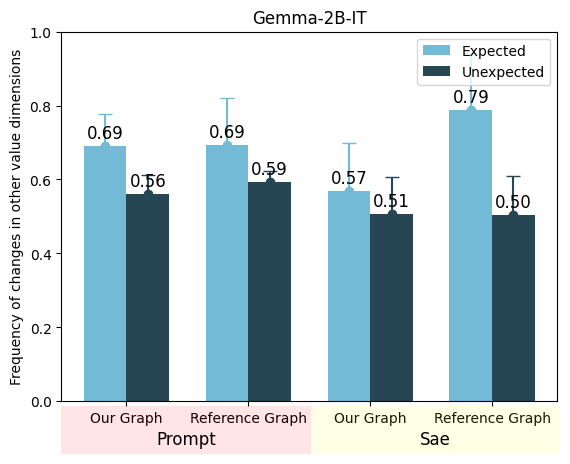

[0.10281528168402629, 0.07069480227766611, 0.20389995912090242, 0.12172279268734836] [0.059903643350865475, 0.07023516605413466, 0.15714556832882876, 0.11959928697178335]
640.0 480.0


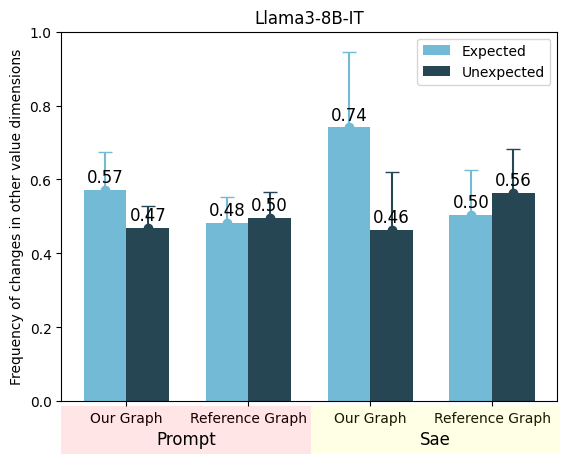

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches



def make_chart(index_dict, modelname):
    data1 = [
        np.nanmean(index_dict['mean_scorechange__prompt_ours_expected']), 
        np.nanmean(index_dict['mean_scorechange__prompt_refs_expected']),
        np.nanmean(index_dict['mean_scorechange__sae_ours_expected']),
        np.nanmean(index_dict['mean_scorechange__sae_refs_expected'])
        ]
    data2 = [
        np.nanmean(index_dict['mean_scorechange__prompt_ours_unexpected']),
        np.nanmean(index_dict['mean_scorechange__prompt_refs_unexpected']),
        np.nanmean(index_dict['mean_scorechange__sae_ours_unexpected']),
        np.nanmean(index_dict['mean_scorechange__sae_refs_unexpected'])
        ]
    #Also keep the standard deviation of each group
    data1_std = [
        np.nanstd(index_dict['mean_scorechange__prompt_ours_expected']),
        np.nanstd(index_dict['mean_scorechange__prompt_refs_expected']),
        np.nanstd(index_dict['mean_scorechange__sae_ours_expected']),
        np.nanstd(index_dict['mean_scorechange__sae_refs_expected'])
        ]
    data2_std = [
        np.nanstd(index_dict['mean_scorechange__prompt_ours_unexpected']),
        np.nanstd(index_dict['mean_scorechange__prompt_refs_unexpected']),
        np.nanstd(index_dict['mean_scorechange__sae_ours_unexpected']),
        np.nanstd(index_dict['mean_scorechange__sae_refs_unexpected'])
    ]
    print(data1_std, data2_std)

    labels_ = ['Our Graph','Reference Graph','Our Graph','Reference Graph']
    
    #用来为坐标的常规坐标 还是 对数坐标做准备
    fig, ax = plt.subplots(figsize=(6.4, 4.8))#用来控制图片的大小
    #fig, ax = plt.subplots()


    # 设置柱状图参数
    width = 0.35 #柱状图每个柱子的宽度,同时也是调整每组柱子之间的间隙
    x = np.arange(len(labels_)) #用来指定每个柱子位置参数
    
    # 绘制柱状图,正常坐标,别忘了errorbar
    ax.errorbar(x-width/2, (data1), yerr=data1_std, fmt='o', color=(115/255, 186/255, 214/255), capsize=5)
    ax.errorbar(x+width/2, (data2), yerr=data2_std, fmt='o', color=(38/255, 70/255, 83/255), capsize=5)


    ax.bar(x-width/2, (data1), width=width, label='Expected',  color=(115/255, 186/255, 214/255)) #edgecolor='#2596be', facecolor='none', hatch='//',
    ax.bar(x+width/2, (data2), width=width, label='Unexpected', color=(38/255, 70/255, 83/255)) #hatch='xx', 
    #change the color of the bars

    # 给每个柱条添加数值标签
    for a, b in zip(x-width/2, data1):
        plt.text(a, b+0.01, '%.2f' % b, ha='center', va='bottom', fontsize=12)
    for a, b in zip(x+width/2, data2):
        plt.text(a, b+0.01, '%.2f' % b, ha='center', va='bottom', fontsize=12)

    # 设置y轴范围, 
    plt.ylim(0, 1)
    

    # 设置图表标题和轴标签
    plt.title(f'{modelname}')
    #plt.xlabel('Order')
    plt.ylabel('Frequency of changes in other value dimensions')
    
    #plt.xticks(x, fontsize=12, rotation=45,loc='inside')#设置标签的文字大小和旋转方向
    plt.xticks(x, labels_)  #使得标签现实的是给定的文字标签


    p1 = patches.Rectangle((.515, 0), width=.39, height=.10, alpha=.1, facecolor='yellow', transform=fig.transFigure)
    p2 = patches.Rectangle((.125, 0), width=.39, height=.10, alpha=.1, facecolor='red', transform=fig.transFigure)
    #can we add a label for each rectangle?

    fig.add_artist(p1)
    fig.add_artist(p2)

    fig.text(0.125 + 0.39/2, .03, 'Prompt', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=12, 
            color='black')
    fig.text(0.515 + 0.39/2, .03, 'Sae', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=12, 
            color='black')

    # 设置图例
    plt.legend(loc='upper right', ncol=1)#设置图例的位置和列数
    
    #获取默认图片尺寸
    figure = plt.gcf()
    width = figure.bbox.width
    height = figure.bbox.height
    print(width,height)
    
    #plt.tight_layout(pad=10)

    # 显示图表
    plt.show()


make_chart(index_dict_gemma, 'Gemma-2B-IT')
make_chart(index_dict_llama, 'Llama3-8B-IT')

In [35]:
#steer_dims = ['nan', 1312, 1341, 2221, 3183, 6619, 7502, 8387, 10096, 14049]

nodes = {}
for entity in v_inference:
    nodes[entity] = os.path.join('valuebench','value_questions_' + entity + '.html'),
# for feature in data_csv.['steer_dim'].unique()[1:]:
#     nodes[feature] = 'https://www.neuronpedia.org/' + sae.cfg.model_name +'/' + str(sae.cfg.hook_layer) + '-res-jb/' + str(feature)

print(len(edges_gemma_total), len(edges_llama_total), len(edges_ref))
edges = {
    'gemma': edges_gemma_total,
    'llama': edges_llama_total,
    'reference': edges_standard_small,
    'gemma_gen': edges_gemma_gen,
    'llama_gen': edges_llama_gen,
    'valuebench': edges_valuebench,
    'human1': edges_human1,
}

json_object = {
    'nodes': nodes,
    'edges': edges
    }

json.dump(json_object, open('value_graph_data1.json', 'w'))


28 19 18
